In [95]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import mlab
import scipy as sp
import seaborn as sns # statistical visualisation
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn import preprocessing as pp

%matplotlib inline 
sns.set() # to have nore appealing visualisations

In [2]:
# Reads file at given location
# Returns dataframe corresponding to data in file
def read_file(filepath):
    column_names = [
                    'index', 'date', 'open', 
                    'high', 'low', 'close',
                    'adj_close', 'volume', 
                    'div_amt', 'split_coeff'
                   ]
    df = pd.read_csv(filepath, skiprows=1, header=None, names=column_names, index_col=['date'], parse_dates=['date'])
    df.drop(columns=['index'], inplace=True)
    return df

filepath = '../data/alphaVantage/INX-full-daily_adjusted.csv'
stocks = read_file(filepath)
print(stocks.info())
stocks.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4731 entries, 2018-10-19 to 2000-01-03
Data columns (total 8 columns):
open           4731 non-null float64
high           4731 non-null float64
low            4731 non-null float64
close          4731 non-null float64
adj_close      4731 non-null float64
volume         4731 non-null int64
div_amt        4731 non-null float64
split_coeff    4731 non-null float64
dtypes: float64(7), int64(1)
memory usage: 332.6 KB
None


,open,high,low,close,adj_close,volume,div_amt,split_coeff
date,,,,,,,,
2018-10-19,2775.6599,2797.7700,2760.2700,2767.7800,2767.7800,3566490000,0.0,1.0
2018-10-18,2802.0000,2806.0400,2755.1799,2768.7800,2768.7800,3616440000,0.0,1.0
2018-10-17,2811.6699,2816.9399,2781.8101,2809.2100,2809.2100,3321710000,0.0,1.0
2018-10-16,2767.0500,2813.4600,2766.9099,2809.9199,2809.9199,3428340000,0.0,1.0
2018-10-15,2763.8301,2775.9900,2749.0300,2750.7900,2750.7900,3300140000,0.0,1.0


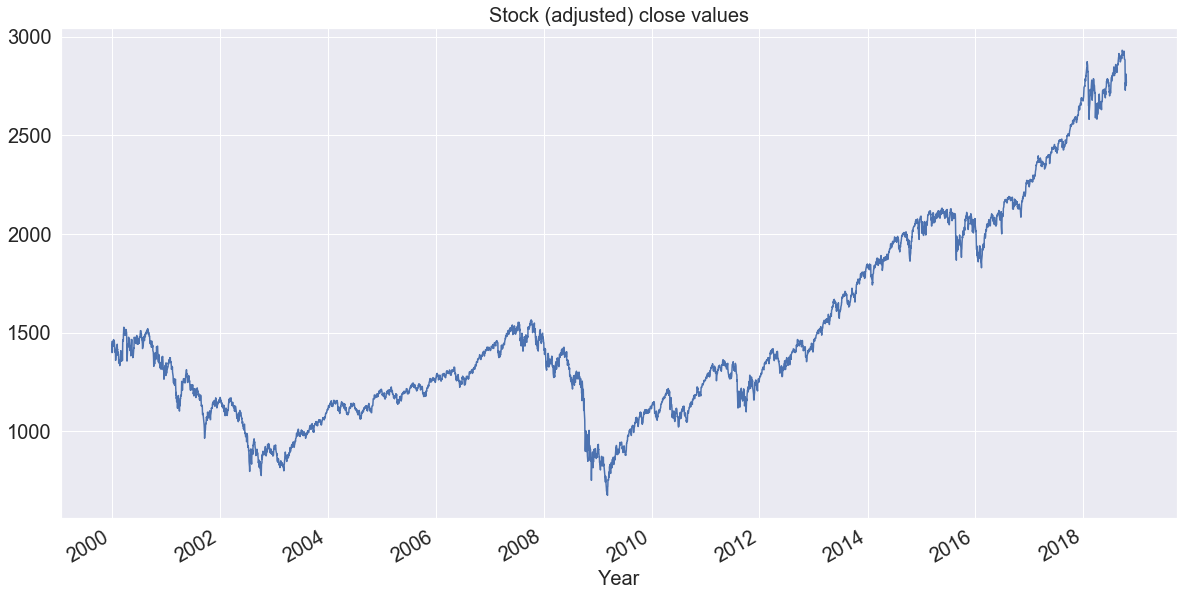

In [3]:
def visualise_plot(df, param, title):
    df[param].plot(figsize=(20,10), fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()
    
visualise_plot(stocks, 'adj_close', 'Stock (adjusted) close values')

## Converting to Returns

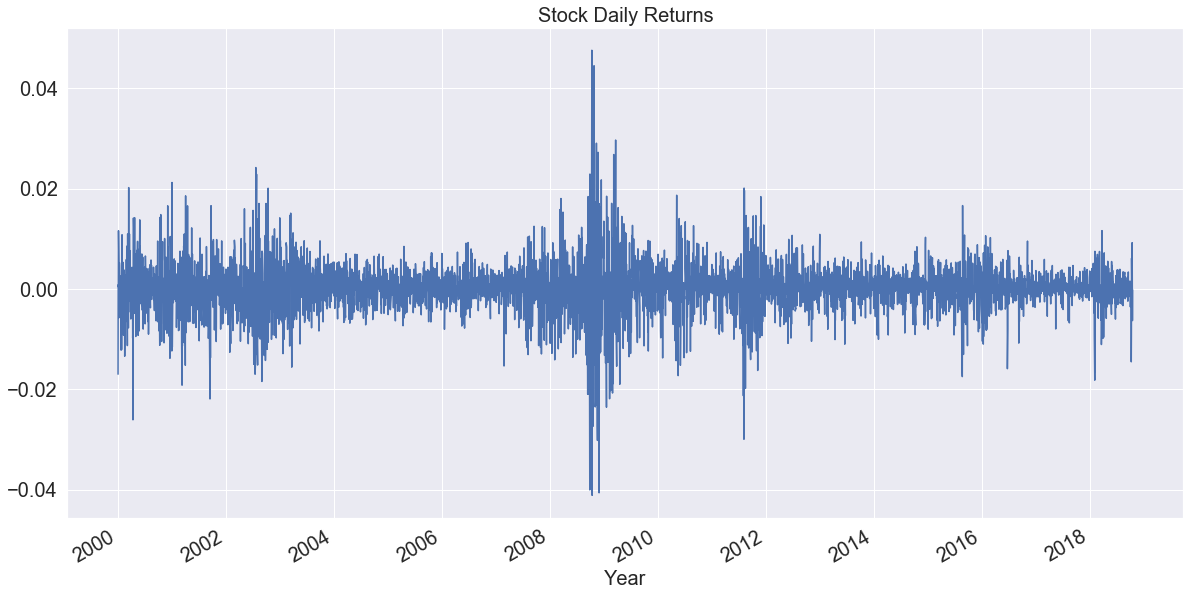

           returns
count  4730.000000
mean      0.000059
std       0.005225
min      -0.041126
25%      -0.002089
50%       0.000227
75%       0.002449
max       0.047586


,returns
2018-10-19,-0.000157
2018-10-18,-0.006296
2018-10-17,-0.000110
2018-10-16,0.009237
2018-10-15,-0.002572


In [4]:
# Returns the daily returns of the stock (Using Taylor series approximation)
def data_log_returns(data):
    log_returns = list()
    date = list()
    for i in range(len(data) - 1):
        abs_t1 = math.log10(data.loc[data.index[i], "adj_close"])
        abs_t0 = math.log10(data.loc[data.index[i + 1], "adj_close"])
        log_returns.append(abs_t1 - abs_t0)
        date.append(data.index[i])
    return pd.DataFrame(log_returns, index=date, columns=['returns'])

stock_returns = data_log_returns(stocks)
visualise_plot(stock_returns, 'returns', 'Stock Daily Returns')
print(stock_returns.describe())
stock_returns.head()

## Scaling
### 1. Standard Scaling

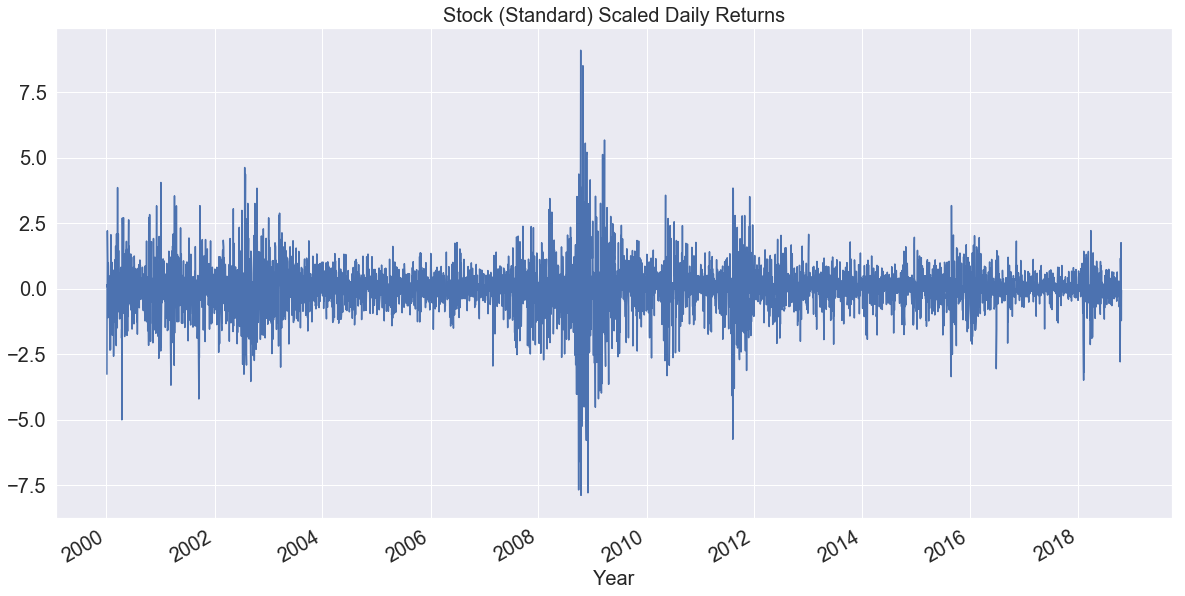

            returns
count  4.730000e+03
mean  -8.356013e-18
std    1.000106e+00
min   -7.883184e+00
25%   -4.111758e-01
50%    3.217684e-02
75%    4.574853e-01
max    9.097278e+00


,returns
2018-10-19,-0.041328
2018-10-18,-1.216375
2018-10-17,-0.032303
2018-10-16,1.756669
2018-10-15,-0.503629


In [5]:
# Standard Scaling the data to get 0 mean and 1 Standard Deviation
def standard_scaling_data(data):
    temp = data
    standardScaler = pp.StandardScaler()
    column_names = temp.columns
    standardScaler.fit(temp)
    data = pd.DataFrame(standardScaler.transform(temp), 
                        index=data.index, 
                        columns = column_names)
    return data

std_scaled_stock_returns = standard_scaling_data(stock_returns)
visualise_plot(std_scaled_stock_returns, 'returns', 'Stock (Standard) Scaled Daily Returns')
print(std_scaled_stock_returns.describe())
std_scaled_stock_returns.head()

### 2. Min-Max Scaling

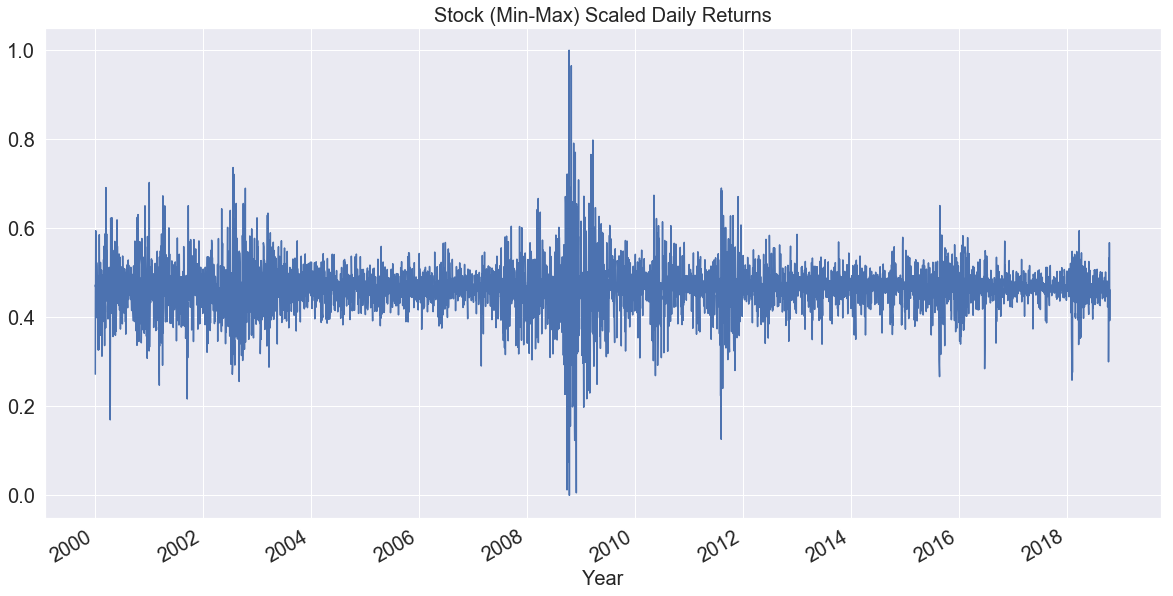

           returns
count  4730.000000
mean      0.464250
std       0.058897
min       0.000000
25%       0.440036
50%       0.466145
75%       0.491192
max       1.000000


,returns
2018-10-19,0.461816
2018-10-18,0.392616
2018-10-17,0.462348
2018-10-16,0.567703
2018-10-15,0.434591


In [24]:
# Standard Scaling the data to get 0 mean and 1 Standard Deviation
def min_max_scaling_data(data, min, max):
    temp = data
    minMaxScaler = pp.MinMaxScaler(feature_range=(min,max))
    column_names = temp.columns
    temp = minMaxScaler.fit_transform(temp)
    data = pd.DataFrame(temp, index=data.index, columns = column_names)
    return data

minmax_scaled_stock_returns = min_max_scaling_data(stock_returns, 0, 1)
visualise_plot(minmax_scaled_stock_returns, 'returns', 'Stock (Min-Max) Scaled Daily Returns')
print(minmax_scaled_stock_returns.describe())
minmax_scaled_stock_returns.head()

## Decomposition
### 1. Rolling Average Trend

In [70]:
# df = stocks
# decomposition_param = 'adj_close'

df = stock_returns
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
decomposition_param = 'returns'

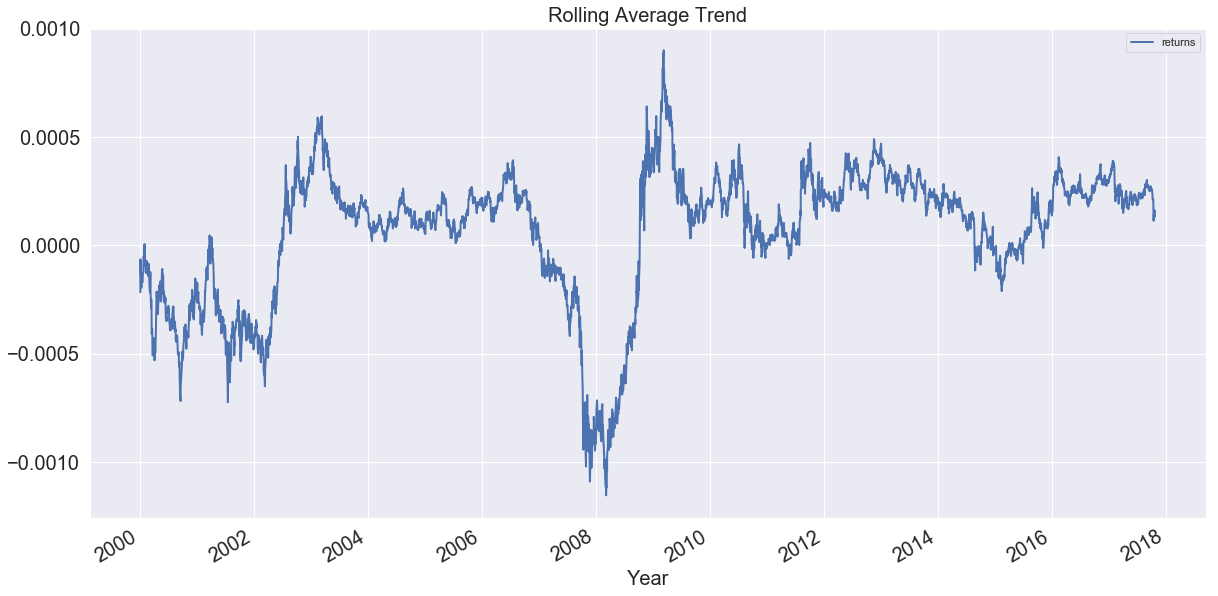

In [71]:
daily_returns = df[[decomposition_param]]
# window size of 252 days rolling around a year (Number of trading days in a year = 252)
daily_returns.rolling(252).mean().plot(figsize=(20,10), linewidth=2, fontsize=20) 
# plotting the trend
plt.title("Rolling Average Trend", fontsize=20)
plt.xlabel('Year', fontsize=20);

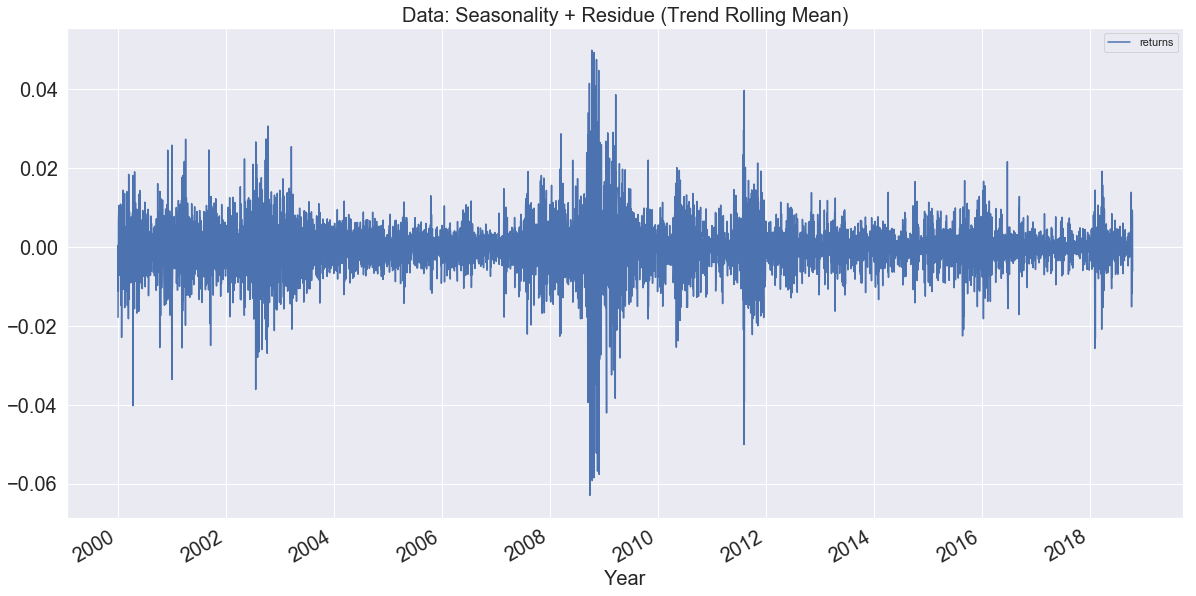

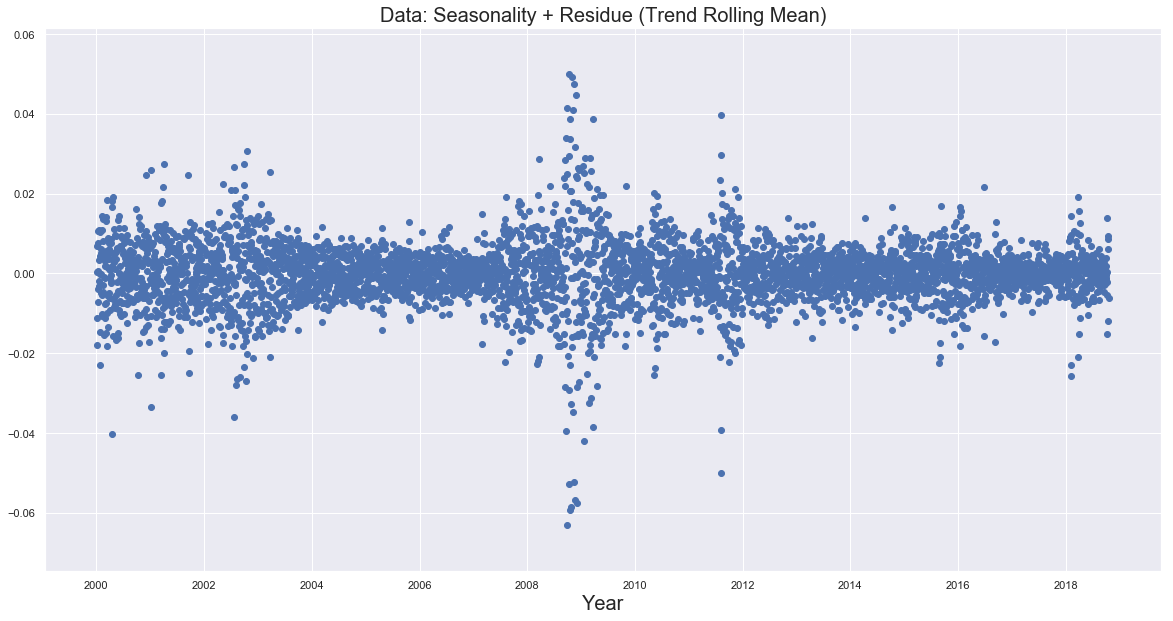

In [9]:
# Removing the trend (to see the seasonality and noise)
daily_returns_detrend = daily_returns.diff()
daily_returns_detrend.plot(figsize=(20,10), fontsize=20)
plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
plt.xlabel('Year', fontsize=20);

# Scatter Plot
plt.figure(figsize=(20, 10))
plt.scatter(daily_returns.index, daily_returns_detrend)
plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
plt.xlabel('Year', fontsize=20);

In [10]:
df[decomposition_param].diff().autocorr(lag=1)

-0.5092984627368863

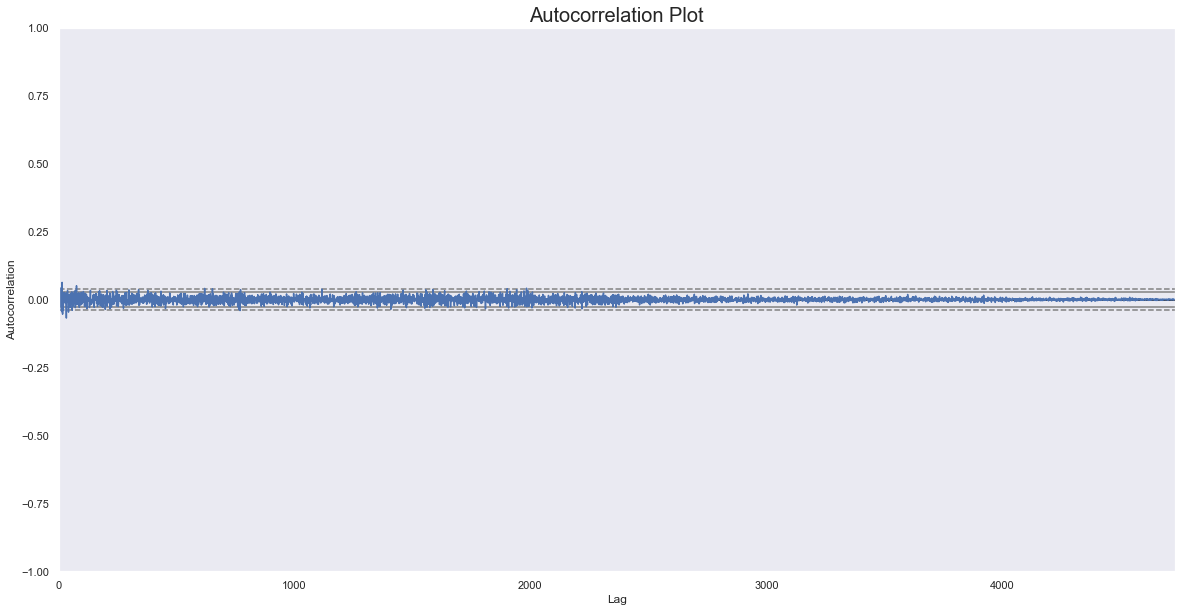

In [11]:
plt.figure(figsize=(20,10))
pd.plotting.autocorrelation_plot(daily_returns)
plt.title('Autocorrelation Plot', fontsize=20);

### 2. Using statsmodel sesasonal_deocmpose
Basics - https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Frequency adjustment - https://stackoverflow.com/a/47610117

In [72]:
df = stocks
decomposition_param = 'adj_close'

# df = stock_returns
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
# decomposition_param = 'returns'

# df = min_max_scaling_data(stock_returns, 1, 2)

Additive Decomposition:


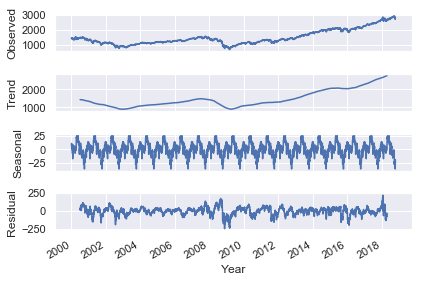

Additive: Seasonlity and Residue


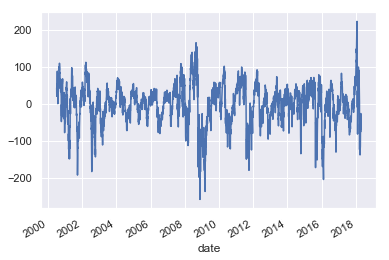

Multiplicative Decomposition:


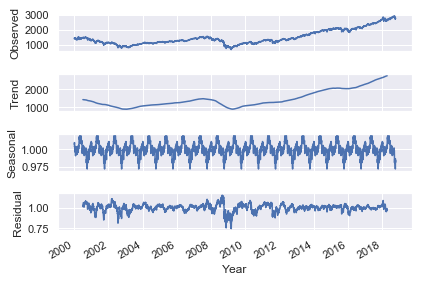

Multiplicative: Seasonlity and Residue


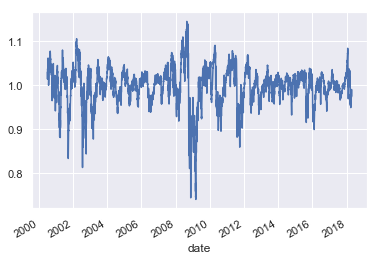

In [34]:
# Uses statsmodel sesasonal_deocmpose to plot the 
# trend, seasonality and residue of the dataframe
def series_decomposition(df, param, model):
    result = seasonal_decompose(df[param], model=model, freq=252)
    result.plot()
    plt.xlabel('Year')
    plt.show()
    return result

print('Additive Decomposition:')    
add_decom = series_decomposition(df, decomposition_param, 'additive')
print('Additive: Seasonlity and Residue')
(add_decom.seasonal + add_decom.resid).plot()
plt.show()


print('Multiplicative Decomposition:')    
mult_decom = series_decomposition(df, decomposition_param, 'multiplicative')
print('Multiplicative: Seasonlity and Residue')
(mult_decom.seasonal*mult_decom.resid).plot()
plt.show()

## Data Properties

### 1. Autocorrelation

In [92]:
# df = stocks
# decomposition_param = 'adj_close'
# decomposition_param_index = 4

# df = stock_returns
# print(stock_returns.head())
# df = std_scaled_stock_returns
df = minmax_scaled_stock_returns
# decomposition_param = 'returns'
decomposition_param_index = 0

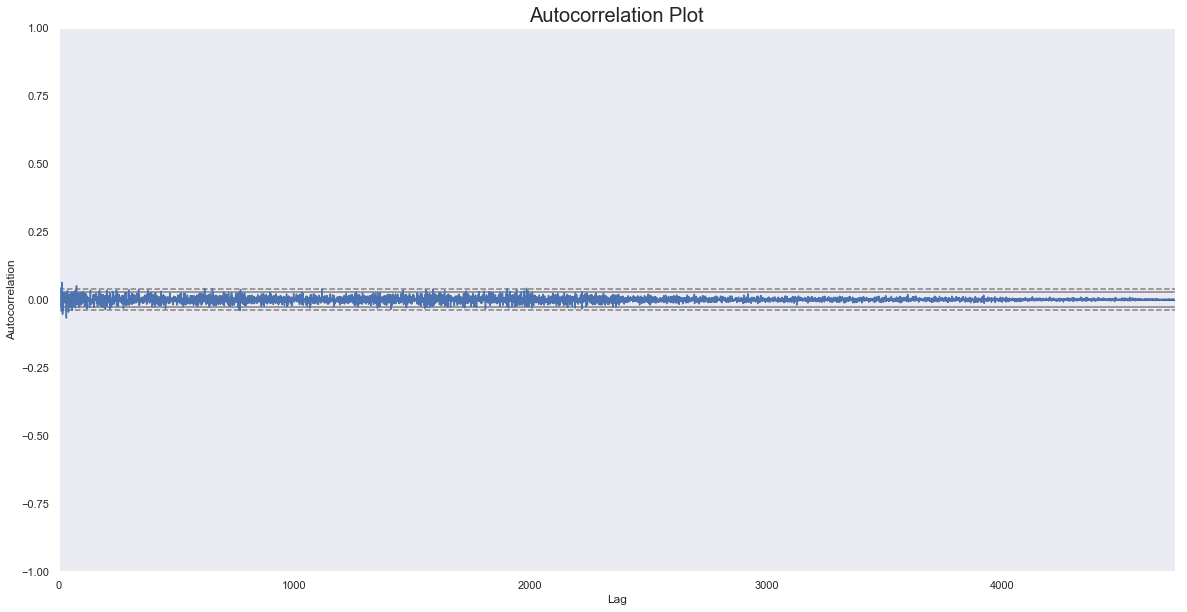

In [93]:
plt.figure(figsize=(20,10))
pd.plotting.autocorrelation_plot(df.iloc[:, decomposition_param_index])
plt.title('Autocorrelation Plot', fontsize=20);

### 2. Distribution

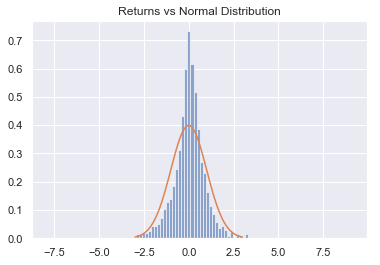

In [130]:
# Generate some data for this demonstration.
data = std_scaled_stock_returns

# Plot the histogram.
data.hist(bins=100, density=True, alpha=0.6)
# data.plot.kde()

# Get parameters of normal distribution:
mu = 0
variance = 1

# Plot the PDF.
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, sp.stats.norm.pdf(x, mu, sigma))

title = "Returns vs Normal Distribution"
plt.title(title)

plt.show()

### 3. Kurtosis and Skew
**Skewness** is usually described as a measure of a dataset’s symmetry – or lack of symmetry.   A perfectly symmetrical data set will have a skewness of 0. The normal distribution has a skewness of 0.  
https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#skewness  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html  
  
**Kurtosis** is all about the tails of the distribution – not the peakedness or flatness.  It measures the tail-heaviness of the distribution. The normal distribution has a kurtosis of 0.  
(Kurtosis is the degree of peakedness of a distribution – Wolfram MathWorld)  
https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#kurtosis  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

In [139]:
print("Skewness: ", sp.stats.skew(std_scaled_stock_returns))
print("Kurtosis: ", sp.stats.kurtosis(std_scaled_stock_returns))

Skewness:  [-0.22470442]
Kurtosis:  [8.68059988]


### 4. Volatility
https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781787123137/15/ch15lvl1sec133/calculating-the-volatility-of-stocks